# Data statistical analysis on the GaN light pollution dataset.


### § Task: Load the final dataset from HW1 and compute the means as requested.


In [1]:
# Install folium
! pip install folium

import pandas as pd
import folium

df = pd.read_csv("2014_to_2024_gan_data_final.csv")


In [2]:
# Compute the mean for: SQMReading, Elevation(m) and CloudCoverPctabs

mean_sqm = df[(df['sqmreading'] >= 0) & (df['sqmreading'] <= 100)]['sqmreading'].mean()
mean_elev = df['elevationm'].mean()
mean_cloud = df['cloudcoverpct'].mean()

print("Mean SQMReading:", mean_sqm)
print("Mean Elevation(m):", mean_elev)
print("Mean CloudCoverPct:", mean_cloud)


Mean SQMReading: 18.156059293099332
Mean Elevation(m): 291.43858507234734
Mean CloudCoverPct: 0.22422293544006913


### § Task: Analyze the SQMReadings and compute the statistics as requested.


In [3]:
# Compute the mean SQMReading when CloudCoverPct is 0. limit the SQMReadings to between 17 and 23
mean_clear = df[(df['cloudcoverpct']==0) & (df['sqmreading'].between(17,23))]['sqmreading'].mean()


In [4]:
print(df.columns.tolist())

['latitude', 'longitude', 'elevationm', 'localdatetime', 'limitingmag', 'sqmreading', 'cloudcoverpct', 'const_bootes', 'const_canis_major', 'const_crux', 'const_cygnus', 'const_gemini', 'const_grus', 'const_hercules', 'const_leo', 'const_none', 'const_orion', 'const_pegasus', 'const_perseus', 'const_sagittarius', 'const_scorpius', 'const_taurus', 'loc_remote', 'loc_rural', 'loc_suburban', 'loc_unknown', 'loc_urban']


In [5]:
df["year"] = pd.to_datetime(df["localdatetime"]).dt.year


In [6]:
# Restrict dataset to 2014–2024 and valid SQM range
df["year"] = pd.to_datetime(df["localdatetime"]).dt.year
df = df[(df["year"].between(2014,2024)) & (df["sqmreading"].between(17,23))]

In [7]:
print(df["year"].min(), df["year"].max())


2014 2024


In [8]:
# Median for all SQMReading data between 17 and 23
median_all = df[df['sqmreading'].between(17,23)]['sqmreading'].median()


In [9]:
# Make sure df is a copy, not a view
df = df.copy()

# Create a single 'region' column from the loc_* indicator columns
region_cols = ['loc_remote', 'loc_rural', 'loc_suburban', 'loc_urban', 'loc_unknown']

def get_region(row):
    for col in region_cols:
        if row[col] == 1:
            return col.replace("loc_", "")
    return "unknown"

df["region"] = df.apply(get_region, axis=1)


In [10]:
# Create a single 'region' column from the loc_* indicator columns
region_cols = ['loc_remote', 'loc_rural', 'loc_suburban', 'loc_urban', 'loc_unknown']

def get_region(row):
    for col in region_cols:
        if row[col] == 1:
            return col.replace("loc_", "")
    return "unknown"

df["region"] = df.apply(get_region, axis=1)


In [11]:
# Median SQMReading by region
median_by_region = df.groupby("region")["sqmreading"].median().reset_index()


In [12]:
# Bortle classification
def bortle_class(sqm):
    if sqm >= 21.99: return 1
    elif sqm >= 21.89: return 2
    elif sqm >= 21.69: return 3
    elif sqm >= 21.25: return 4
    elif sqm >= 20.49: return 5
    elif sqm >= 19.50: return 6
    elif sqm >= 18.95: return 7
    else: return 8

median_by_region["bortle_class"] = median_by_region["sqmreading"].apply(bortle_class)

# Final table with all required columns
table = median_by_region.rename(columns={
    "region": "location",
    "sqmreading": "median_sqm"
})

print(table.to_markdown(index=False))


| location   |   median_sqm |   bortle_class |
|:-----------|-------------:|---------------:|
| remote     |       21.39  |              4 |
| rural      |       21.01  |              5 |
| suburban   |       20.695 |              5 |
| unknown    |       19.65  |              6 |
| urban      |       19.3   |              7 |


In [13]:
# Compute the median SQMReading for urban, suburban, rural and remote regions.
median_regions = df[df['sqmreading'].between(17,23)].groupby(['loc_urban','loc_suburban','loc_rural','loc_remote'])['sqmreading'].median()

In [14]:
mean_clear

19.758494886750846

In [15]:
median_all

19.73

In [16]:
median_regions

loc_urban  loc_suburban  loc_rural  loc_remote
False      False         False      False         19.650
                                    True          21.390
                         True       False         21.010
           True          False      False         20.695
True       False         False      False         19.300
Name: sqmreading, dtype: float64

<Axes: >

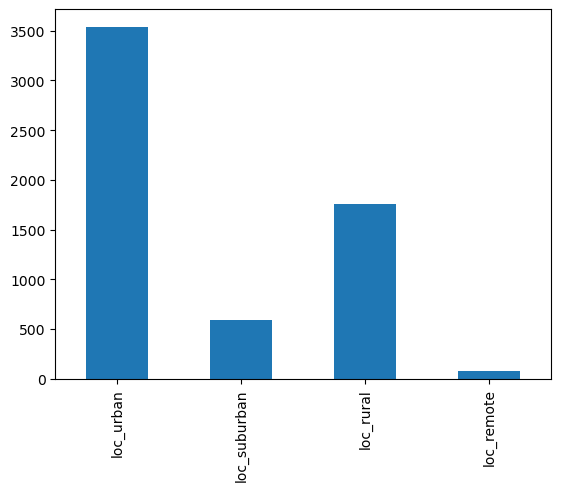

In [17]:
# Plot Bar graph 

region_cols = ['loc_urban','loc_suburban','loc_rural','loc_remote']
df[region_cols].sum().plot.bar()



# § Task: Analyze the correlations between SQMReadings and LimitingMagnitude

In [18]:
# Used DataFrame.corr() to compute the Pearson correlation between LimitingMagnitude and SQMReading.

corr = df[df['sqmreading'].between(17,23)][['sqmreading','limitingmag']].corr()
print(corr)


             sqmreading  limitingmag
sqmreading     1.000000     0.957281
limitingmag    0.957281     1.000000


In [19]:
# Used the provided function bortle_class()

def bortle_class(sqm):
    if sqm > 21.9:
        return 1 
    elif 21.5 <= sqm <= 21.9:
        return 2 
    elif 21.3 <= sqm < 21.5:
        return 3
    elif 20.3 <= sqm < 21.3:
        return 4
    elif 20.1 <= sqm < 20.8:
        return 4.5
    elif 19.1 <= sqm < 20.1:
        return 5
    else:
        return 6
        

In [20]:
# Compute the SQMReading median for each Bortle class in the dataset.

df2 = df[df['sqmreading'].between(17,23)].copy()
df2['bortle'] = df2['sqmreading'].apply(bortle_class)
print(df2.groupby('bortle')['sqmreading'].median().to_markdown())


|   bortle |   sqmreading |
|---------:|-------------:|
|      1   |        22.02 |
|      2   |        21.66 |
|      3   |        21.39 |
|      4   |        20.79 |
|      4.5 |        20.2  |
|      5   |        19.6  |
|      6   |        18.18 |


# § Task: Plot the bar chart frequency of measurements for each of the regions: suburban, urban, rural and remote.


<Axes: >

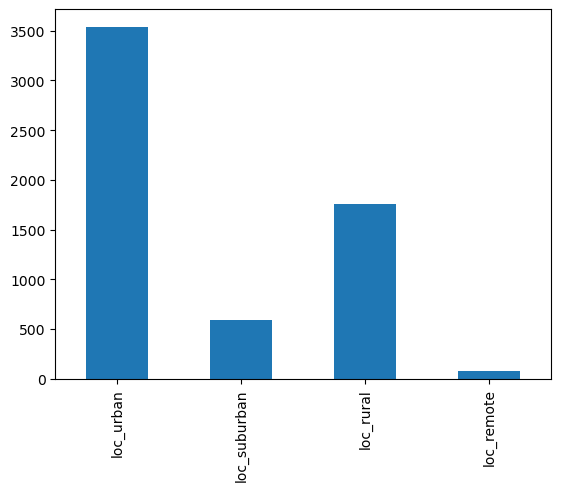

In [21]:
# Code to produce a bar chart with the 𝑥-axis the location and the 𝑦-axis the frequency of that data in the dataset.

region_cols = ['loc_urban','loc_suburban','loc_rural','loc_remote']
df[region_cols].sum().plot.bar()


# § Task: Plot a bar chart plot of the frequency of measurements by day for all data.


<Axes: xlabel='weekday'>

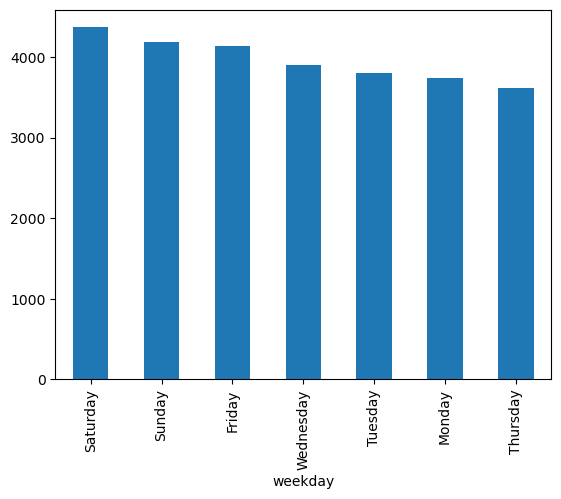

In [22]:
# code to produce a bar chart with the 𝑥-axis the day of the week (i.e. Sunday, Monday, etc.) and the 𝑦-axis the frequency count.

df['weekday'] = pd.to_datetime(df['localdatetime']).dt.day_name()
df['weekday'].value_counts().plot.bar()


# § Task: Plot a pie chart of the frequency of measurements by year for all data

<Axes: ylabel='count'>

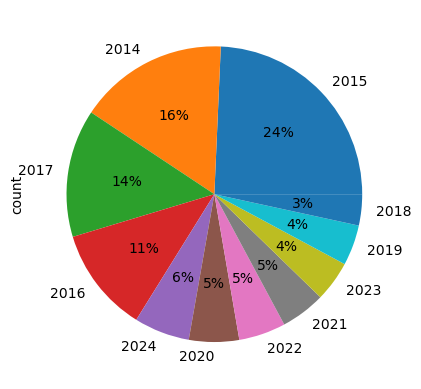

In [23]:
# Code to produce a pie chart with each wedge of the chart representing the number of measurements in each year.

df['year'] = pd.to_datetime(df['localdatetime']).dt.year

df['year'].value_counts().plot.pie(autopct='%1.0f%%')


# § Task: Plot a scatter plot of Longitude and Latitude for all data.

<Axes: xlabel='longitude', ylabel='latitude'>

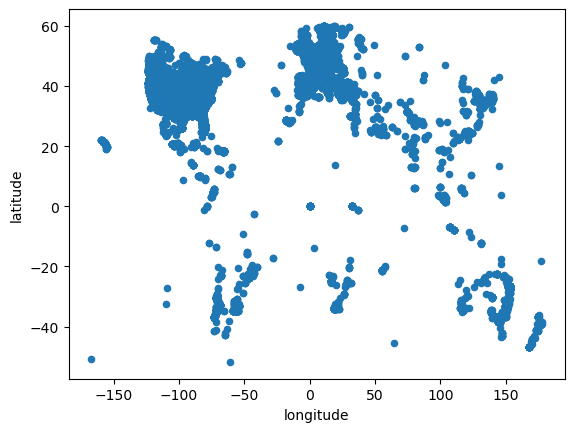

In [24]:
#  Code to produce a scatter plot of all Longitude and Latitude, where longitude is between -180 and +180, and latitude is between -60 and +60. 

df[(df['longitude'].between(-180,180)) & (df['latitude'].between(-60,60))].plot.scatter(x='longitude', y='latitude')


# Used basic Folium to plot geographic data from GaN light pollution data features.


## § Task: Produce a Folium map of all measurements in the southern hemisphere in March 2018.

In [25]:
# Convert datetime

df['date'] = pd.to_datetime(df['localdatetime'])


In [26]:
# The “southern hemisphere” are measurements with Latitude < 0 and Longitude between -180 and +180.

south = df[(df['latitude'] < 0) &
           (df['longitude'].between(-180, 180)) &
           (df['date'].dt.year == 2018) &
           (df['date'].dt.month == 3)]


In [27]:
# Base map (southern hemisphere)
map1 = folium.Map(location=[-20, 0], zoom_start=2)

In [28]:
# pins on the map for all points in that data.
for _, row in south.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Lat:{row['latitude']}, Lon:{row['longitude']}"
    ).add_to(map1)

map1

## § Task: Produce a Folium map with all the SQM measurements from the state of Arkansas from 2015-2024.

In [29]:
#  State of Arkansas from 2015-2024.
# restrict the bounding box of the Folium map to: SW = (33.046122, -94.453836); NE = (36.474896, -89.843373)

SW = (33.046122, -94.453836)
NE = (36.474896, -89.843373)


In [30]:
# Restricted SQMReadings to between 17 and 23
ark = df.copy()
ark['date'] = pd.to_datetime(ark['localdatetime'])
ark = ark[(ark['date'].dt.year.between(2015, 2024)) &
          (ark['latitude'].between(SW[0], NE[0])) &
          (ark['longitude'].between(SW[1], NE[1])) &
          (ark['sqmreading'].between(17,23))]


In [31]:
# Drop missing 

ark = ark.dropna(subset=['sqmreading'])


In [32]:
# Aggregate duplicate locations with groupby() and report the median SQMReading

ark_grouped = ark.groupby(['latitude','longitude'])['sqmreading'].median().reset_index()


In [33]:
# Base map (Arkansas)

map2 = folium.Map(location=[35, -92], zoom_start=6)


In [34]:
# pins includes the Latitude, Longitude and median SQMReading data in the popup.
for _, row in ark_grouped.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Lat:{row['latitude']}, Lon:{row['longitude']}, Median SQM:{row['sqmreading']}"
    ).add_to(map2)

map2